## Prediction in a Time Series Dataset

We are given a time-series dataset, DATASET ROAD, having data for different subsections of a road that is approximately 25 kilometers.

An IoT based company has deployed electronic sensors in order to get the data for 13 different pre-defined parameters and this data has been collected for over 10 years.

We need to use this time-series data in order to predict the values of the Parameters 9,10,11,12 and 13 for the 10th year and compare the predicted values and actual values.

The model that we will use for this purpose is XGBoost Regressor and the Total Root Mean Square Error that we obtain using this mode is 26.2587%.

### Importing Libraries and Reading the dataset

In [1]:
# Importing basic libraries required for various computations and visulations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_excel('DATASET.xlsx')
dataset

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,NaN,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,NaN,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,NaN,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,NaN,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [3]:
dataset.shape

(1009, 15)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  101 non-null    object 
 1   year        1009 non-null   int64  
 2   Para-1      1009 non-null   float64
 3   Para-2      1009 non-null   float64
 4   Para-3      1009 non-null   float64
 5   Para-4      1009 non-null   float64
 6   Para-5      1009 non-null   int64  
 7   Para-6      1009 non-null   int64  
 8   Para-7      1009 non-null   int64  
 9   Para-8      1009 non-null   int64  
 10  Para-9      1009 non-null   float64
 11  Para-10     1009 non-null   float64
 12  Para-11     1009 non-null   float64
 13  Para-12     1009 non-null   int64  
 14  Para-13     1007 non-null   float64
dtypes: float64(8), int64(6), object(1)
memory usage: 118.4+ KB


### Preprocessing of Data before Modelling

On observing the dataset we can tell that Section 92 of the dataset has data for only 9 years instead of 10 years. Hence, we will  remove the data for Section 92.

In [5]:
dataset.drop(dataset.index[910:919], inplace = True)

In [6]:
dataset.shape

(1000, 15)

In [7]:
#Renaming Unnamed: 0 column as Section_Name
dataset.columns = dataset.columns.str.replace('Unnamed: 0', 'Section_Name')

In [8]:
#Replacing all NaN values in Section_Name column with corresponding name of the section
dataset["Section_Name"].ffill(inplace=True)

In [9]:
dataset.fillna(0, inplace=True) #Replacing NULL values in the dataset with 0

In [10]:
dataset.head(10)

,Section_Name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80
5,Sec_1,6,324.0,225.0,17.2,0.0,4,114,6630,1500,0.0,24.9,0.0,7,1.81
6,Sec_1,7,324.0,130.0,18.4,0.0,3,103,6700,1540,0.9,25.2,0.0,7,1.86
7,Sec_1,8,324.0,100.6,19.0,0.0,2,114,6740,1590,0.9,52.8,0.0,8,1.89
8,Sec_1,9,324.0,176.5,19.0,0.0,3,108,7175,1787,3.4,60.5,57.0,8,1.92
9,Sec_1,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.96


### Extracting Test data from the dataset

In [11]:
test_dataset = dataset.loc[dataset['year'] == 10]
test_dataset

,Section_Name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
9,Sec_1,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.960
19,Sec_2,10,327.7,62.0,22.7,0.0,2,102,30525,10234,76.5,44.3,5.0,9,0.795
29,Sec_3,10,487.7,93.2,22.5,0.0,4,110,2140,1270,78.5,0.0,0.0,16,1.432
39,Sec_4,10,543.6,93.2,22.5,0.0,4,110,2140,1270,28.5,60.5,67.0,11,2.004
49,Sec_5,10,434.4,149.0,11.7,72.0,3,110,13142,6225,0.0,276.2,34.0,6,1.792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,Sec_97,10,514.0,1226.4,10.1,203.6,16,114,7672,303,219.7,206.2,10.0,8,1.607
978,Sec_98,10,901.0,1531.0,11.1,34.9,40,100,15150,1077,5.9,74.5,33.0,13,1.087
988,Sec_99,10,1181.0,1364.9,9.2,274.3,24,112,12500,880,131.4,72.4,18.0,12,0.996
998,Sec_100,10,662.0,1110.7,12.8,33.2,27,117,3324,1356,193.7,305.6,180.0,12,2.212


### Time Series Modelling

We have imported the required libraries that are needed for training the model using XGBoost Regressor and evaluating results using Root Mean Square Error.

In [12]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math

In [13]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

Now, we will create a new dataframe for all the predicted values as predicted by the XGB Regressor 

In [14]:
prediction_parameters = {'Para-9': [], 'Para-10': [], 'Para-11': [], 'Para-12': [], 'Para-13': []}
prediction_parameters_name = ['Para-9', 'Para-10', 'Para-11', 'Para-12', 'Para-13']

In [15]:
counter = 0
index = 0
root_mean_square_error = []

for j in [10, 11, 12, 13, 14]:
  answer = 0
  count = 0

  for i in range(0, 1000, 10):
    train_x = dataset.iloc[i:i+9, 1:10].values
    test_x = dataset.iloc[i+9, 1:10].to_numpy()
    train_y = dataset.iloc[i:i+9, j]
    test_y = dataset.iloc[i+9, j]

    reg.fit(train_x, train_y)

    predicted_y = reg.predict(test_x.reshape(1,-1))[0]
    prediction_parameters[prediction_parameters_name[index]].append(predicted_y)

    answer += (test_y - predicted_y)**2
    count += 1
    counter += 1

  root_mean_square_error.append(answer)
  index += 1


### Predicted Values Dataset

In [16]:
df_pred = pd.DataFrame.from_dict(prediction_parameters).round(2)
df_pred

,Para-9,Para-10,Para-11,Para-12,Para-13
0,3.400000,60.500000,57.0,8.0,1.92
1,60.900002,30.200001,1.0,8.0,0.79
2,75.400002,0.000000,0.0,14.0,1.41
3,24.799999,57.299999,64.0,8.0,1.89
4,0.000000,261.799988,34.0,6.0,1.77
...,...,...,...,...,...
95,189.399994,191.699997,10.0,8.0,1.55
96,5.200000,71.099998,24.0,12.0,1.08
97,122.199997,67.699997,15.0,12.0,0.98
98,140.800003,292.799988,167.0,12.0,2.12


### Calculating Root Mean Square Error for Parameter 9,10,11,12 and 13

In [17]:
parameter_num = 9
for x in root_mean_square_error:
  print("Root Mean Square Error for Para-"+str(parameter_num)+": "+str((x/count)**0.5))
  parameter_num = parameter_num + 1

Root Mean Square Error for Para-9: 43.54983365098167
Root Mean Square Error for Para-10: 34.09742448784311
Root Mean Square Error for Para-11: 14.154722172990521
Root Mean Square Error for Para-12: 13.712451601171981
Root Mean Square Error for Para-13: 0.10271141433220694


### Calculating Total Root Mean Square Error

In [18]:
total_root_mean_square_error = (sum(root_mean_square_error)/counter)**0.5
print("Total Root Mean Square Error is: "+ str(total_root_mean_square_error))

Total Root Mean Square Error is: 26.258790551264944


### Plotting the Results for 25 datapoints


In [19]:
plt.style.use("seaborn-whitegrid")

In [20]:
selected_row = []
for i in range(25):
  selected_row.append(random.randint(0,100))    #Selecting 25 random values from the 100 test values

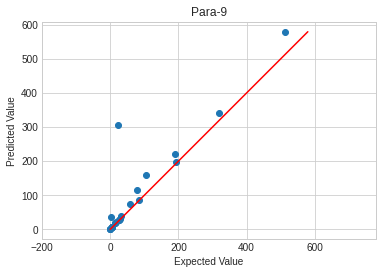

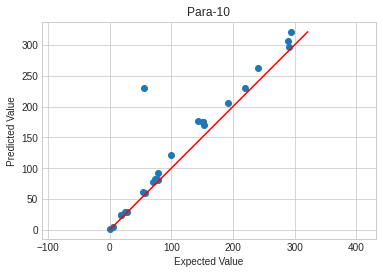

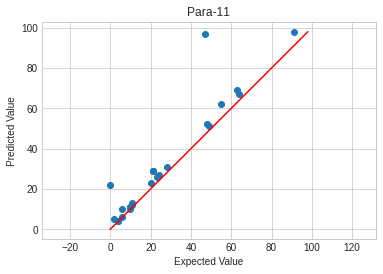

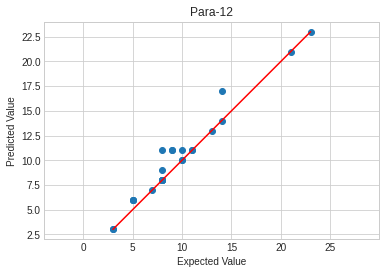

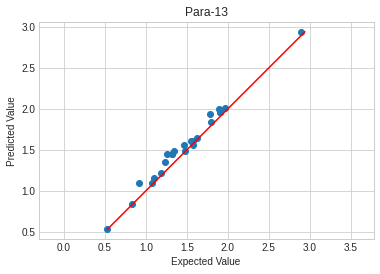

In [21]:
for i in range(5):      #Plotting expected vs predicted values for a random 25 values taken from test dataset

  true_value = df_pred.iloc[selected_row, i]
  predicted_value = test_dataset.iloc[selected_row, i + 10]
  plt.scatter(true_value, predicted_value)

  p1 = max(max(predicted_value), max(true_value))
  p2 = min(min(predicted_value), min(true_value))

  plt.plot([p1, p2], [p1, p2], 'r-') 
  plt.title(prediction_parameters_name[i])
  plt.xlabel('Expected Value', fontsize=10)
  plt.ylabel('Predicted Value', fontsize=10)
  plt.axis('Equal')

  count +=1 
  plt.show()

### Plotting all Predicted vs Expected Values

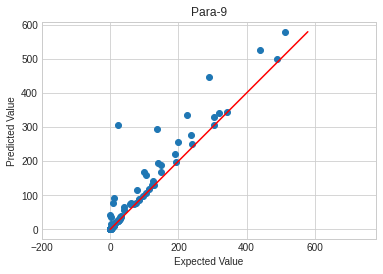

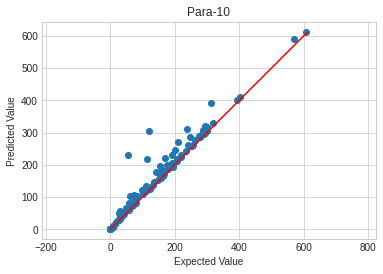

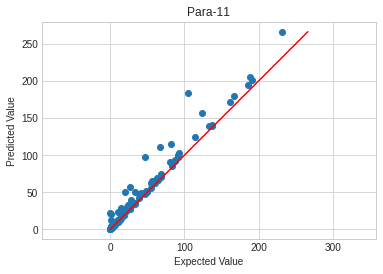

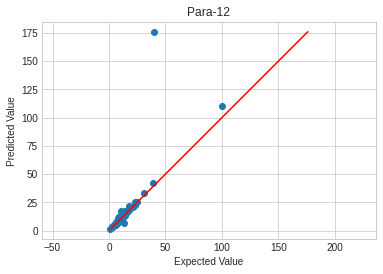

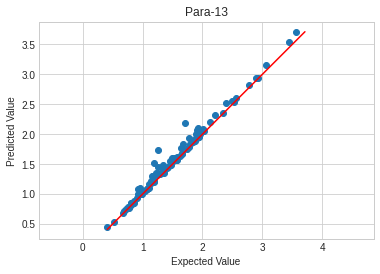

In [22]:
for i in range(5):
  true_value = df_pred.iloc[:, i]
  predicted_value = test_dataset.iloc[:, i + 10]
  plt.scatter(true_value, predicted_value)

  p1 = max(max(predicted_value), max(true_value))
  p2 = min(min(predicted_value), min(true_value))
  plt.plot([p1, p2], [p1, p2], 'r-')
  plt.title(prediction_parameters_name[i])
  plt.xlabel('Expected Value', fontsize=10)
  plt.ylabel('Predicted Value', fontsize=10)
  plt.axis('Equal')
  plt.show()

The final root mean square error obtained after using this XGB Regressor Model is 26.258790551264944% which is a very good value. Hence, this is a good model for time series predictions